#Synthetic Stellar Population: IMF Sampling and Remnant Outcomes

This script generates a synthetic stellar population and evolves it over 10 Gyr using a Monte-Carlo sampling of the Kroupa IMF, a constant star-formation history, and analytic main-sequence lifetimes. Stars that have already ended their lives are assigned compact remnants (white dwarfs, neutron stars, or black holes) using literature initial–final mass relations, including probabilistic treatment of overlapping mass ranges. The output is a full initial–final population along with diagnostic plots of the resulting distributions.

In [1]:
# Centralized imports
import numpy as np
from numpy import exp, log10 as log
import matplotlib.pyplot as plt
from dataclasses import dataclass

# RNG global por reproducibilidad (puedes cambiar la semilla)
rng = np.random.default_rng(2024)


Next we define the Kroupa (2001) IMF as piecewise power-law segments and compute the amplitude factors that guarantee continuity between segments.

In [ ]:
# Kroupa sampling by segments (with continuity amplitudes)
KROUPA_SEGMENTS = ((0.01, 0.08, 0.3), (0.08, 0.5, 1.3), (0.5, 120.0, 2.3))
KROUPA_AMPLITUDES = []
for i, (low, high, alpha) in enumerate(KROUPA_SEGMENTS):
    if i == 0:
        KROUPA_AMPLITUDES.append(1.0)
    else:
        _, _, prev_alpha = KROUPA_SEGMENTS[i-1]
        b = low
        KROUPA_AMPLITUDES.append(KROUPA_AMPLITUDES[-1] * b**(alpha - prev_alpha))
KROUPA_AMPLITUDES = np.asarray(KROUPA_AMPLITUDES)

def _powerlaw_integral(m_low, m_high, alpha):
    """Analytic integral of m^{-alpha} over [m_low, m_high].
    """
    exponent = 1.0 - alpha
    if np.isclose(exponent, 0.0):
        return np.log(m_high / m_low)
    return (m_high**exponent - m_low**exponent) / exponent

def _sample_powerlaw(m_low, m_high, alpha, size, rng):
    """Inverse-CDF sampling over a segment ∝ m^{-alpha}.
    """
    exponent = 1.0 - alpha
    u = rng.random(size)
    if np.isclose(exponent, 0.0):
        return m_low * (m_high / m_low) ** u
    low_term = m_low**exponent; high_term = m_high**exponent
    return (low_term + (high_term - low_term) * u) ** (1.0 / exponent)

def sample_kroupa_masses(size, m_min=0.01, m_max=120.0, rng=None):
    """Sample initial masses according to Kroupa (2001).
    Returns ndarray of given `size`.
    """
    rng = np.random.default_rng(rng)
    active_segments, weights = [], []
    for idx_all, (low, high, alpha) in enumerate(KROUPA_SEGMENTS):
        seg_low = max(low, m_min); seg_high = min(high, m_max)
        if seg_low >= seg_high: continue
        active_segments.append((seg_low, seg_high, alpha, idx_all))
        amp = KROUPA_AMPLITUDES[idx_all]
        weights.append(amp * _powerlaw_integral(seg_low, seg_high, alpha))
    weights = np.asarray(weights)
    cdf = np.cumsum(weights) / weights.sum()
    segment_choices = np.searchsorted(cdf, rng.random(size))
    samples = np.empty(size)
    for idx, (seg_low, seg_high, alpha, _) in enumerate(active_segments):
        mask = segment_choices == idx
        if not np.any(mask): continue
        samples[mask] = _sample_powerlaw(seg_low, seg_high, alpha, mask.sum(), rng)
    return samples

def plot_kroupa_sampling_diagnostics(masses):
    """Histograma (density=True) vs IMF normalizada.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    bins = np.logspace(np.log10(masses.min()), np.log10(masses.max()), 100)
    ax.hist(masses, bins=bins, density=True, histtype="step", color="k", lw=1.5, label="Monte Carlo")
    m_grid = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), 400)
    pdf = kroupa01(m_grid); pdf /= np.trapz(pdf, m_grid)
    ax.plot(m_grid, pdf, color="tab:orange", label="Kroupa normalized")
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_xlabel("Initial mass [M_\odot]"); ax.set_ylabel("Probability density")
    ax.legend(); fig.tight_layout(); return fig, ax


<>:63: SyntaxWarning: invalid escape sequence '\o'
<>:63: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_6662/1412887099.py:63: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel("Initial mass [M_\odot]"); ax.set_ylabel("Probability density")


In [ ]:
# Pipeline: sample initial masses
stellar_masses = sample_kroupa_masses(size=1_000_000, m_min=0.08, m_max=100.0, rng=rng)
# _ = plot_kroupa_sampling_diagnostics(stellar_masses)  # opcional


Assigns each star a random birth time within the Galaxy's age and computes its main-sequence lifetime via a mass-lifetime power law.
Determines whether each star has evolved into a compact remnant.

In [ ]:
# Assign formation times and MS lifetimes
AGE_MW_GYR = 10.0
birth_times_gyr = rng.uniform(0.0, AGE_MW_GYR, size=stellar_masses.size)
stellar_ages_gyr = AGE_MW_GYR - birth_times_gyr
T_SUN_GYR = 10.0
t_ms_gyr = T_SUN_GYR * stellar_masses ** -2.5
stellar_is_remnant = stellar_ages_gyr > t_ms_gyr


Defines initial-final mass relations for white dwarfs, neutron stars, and black holes from the literature (Kalirai 2008, Raithel 2018).
Each function maps initial mass → final mass.

In [ ]:
# IFMRs and remnant channels
def wd_ifmr_kalirai(m_init):
    """Kalirai et al. (2008) IFMR for white dwarfs.
    Returns M_f [M_sun].
    """
    m_init = np.asarray(m_init, dtype=float)
    return 0.109 * m_init + 0.394

def ns_ifmr_eq11(m_init):
    """Raithel et al. (2018) Eq. 11.
    """
    m_init = np.asarray(m_init, dtype=float)
    delta = m_init - 14.75
    return 2.24 + 0.508 * delta + 0.125 * delta ** 2 + 0.0110 * delta ** 3

def ns_ifmr_eq12(m_init):
    """Raithel et al. (2018) Eq. 12.
    """
    m_init = np.asarray(m_init, dtype=float)
    return 0.123 + 0.112 * m_init

def ns_ifmr_eq13(m_init):
    """Raithel et al. (2018) Eq. 13.
    """
    m_init = np.asarray(m_init, dtype=float)
    return 0.996 + 0.0384 * m_init

def ns_ifmr_eq14(m_init):
    """Raithel et al. (2018) Eq. 14.
    """
    m_init = np.asarray(m_init, dtype=float)
    return -0.020 + 0.10 * m_init

def bh_mass_core_low(m_init):
    """Low-Z (core).
    """
    m_init = np.asarray(m_init, dtype=float)
    return -2.049 + 0.4140 * m_init

def bh_mass_all_low(m_init):
    """Low-Z (total mass polynomial).
    """
    m_init = np.asarray(m_init, dtype=float)
    delta = m_init - 25.97
    return 15.52 + 0.3294 * delta - 0.02121 * delta ** 2 + 0.003120 * delta ** 3

def bh_mass_low(m_init, f_eject=0.9):
    """Mixture: core vs total; f_eject weights the core term.
    """
    core = bh_mass_core_low(m_init); all_low = bh_mass_all_low(m_init)
    return f_eject * core + (1.0 - f_eject) * all_low

def bh_mass_high(m_init):
    """High-mass (fallback-limited).
    """
    m_init = np.asarray(m_init, dtype=float)
    return 5.697 + 7.8598e8 * m_init ** -4.858

REMNANT_TYPE_LABELS = {0: 'MainSequence', 1: 'WhiteDwarf', 2: 'NeutronStar', 3: 'BlackHole', 4: 'UnknownRemnant'}
REMNANT_COLORS = {1: 'tab:blue', 2: 'tab:orange', 3: 'tab:purple'}

@dataclass
class RemnantChannel:
    label: str
    type_code: int
    mass_min: float
    mass_max: float
    mass_function: callable

REMNANT_CHANNELS = (
    RemnantChannel('WD_Kalirai2008', 1, 0.5, 9.0, wd_ifmr_kalirai),
    RemnantChannel('NS_Eq11', 2, 9.0, 13.0, ns_ifmr_eq11),
    RemnantChannel('NS_Eq12', 2, 13.0, 15.0, ns_ifmr_eq12),
    RemnantChannel('NS_Eq13', 2, 15.0, 17.8, ns_ifmr_eq13),
    RemnantChannel('NS_Eq14', 2, 17.8, 18.5, ns_ifmr_eq14),
    RemnantChannel('BH_Low', 3, 15.0, 42.22, bh_mass_low),
    RemnantChannel('BH_High', 3, 42.22, np.inf, bh_mass_high),
)


# Remnant channel selection and final masses
remnant_indices = np.where(stellar_is_remnant)[0]
if remnant_indices.size == 0:
    print('No remnants in the current Monte Carlo sample.')
else:
    remnant_init_masses = stellar_masses[remnant_indices]
    channel_masks = []
    for channel in REMNANT_CHANNELS:
        mask = remnant_init_masses >= channel.mass_min
        if np.isfinite(channel.mass_max): mask &= remnant_init_masses < channel.mass_max
        channel_masks.append(mask)
    channel_masks = np.vstack(channel_masks)
    candidate_counts = channel_masks.sum(axis=0)
    selected_channel = np.full(remnant_init_masses.size, -1, dtype=np.int16)
    unique_mask = candidate_counts == 1
    if np.any(unique_mask):
        for idx, mask in enumerate(channel_masks):
            assign = mask & unique_mask; selected_channel[assign] = idx
    overlap_idx = np.where(candidate_counts > 1)[0]
    if overlap_idx.size:
        overlap_rng = np.random.default_rng(rng.integers(0, 2**32 - 1))
        for star_idx in overlap_idx:
            valid_channels = np.flatnonzero(channel_masks[:, star_idx])
            selected_channel[star_idx] = overlap_rng.choice(valid_channels)
    remnant_final_masses = np.full(remnant_init_masses.size, np.nan)
    remnant_type_codes = np.full(remnant_init_masses.size, 4, dtype=np.int8)
    for idx, channel in enumerate(REMNANT_CHANNELS):
        mask = selected_channel == idx
        if not np.any(mask): continue
        remnant_final_masses[mask] = channel.mass_function(remnant_init_masses[mask])
        remnant_type_codes[mask] = channel.type_code
    stellar_final_mass = np.full(stellar_masses.size, np.nan)
    stellar_final_mass[remnant_indices] = remnant_final_masses
    stellar_remnant_type = np.zeros(stellar_masses.size, dtype=np.int8)
    stellar_remnant_type[remnant_indices] = remnant_type_codes


Set of dedicated plotting utilities to visualize the population synthesis outputs:

In [ ]:
# Plotting functions (Plots 1–5)
def plot_ifmr_scatter(scatter_init, scatter_final, scatter_types):
    fig, ax = plt.subplots(figsize=(6,4))
    for type_code, color in REMNANT_COLORS.items():
        mask = scatter_types == type_code
        if np.any(mask): ax.scatter(scatter_init[mask], scatter_final[mask], s=8, alpha=0.4, label=REMNANT_TYPE_LABELS[type_code], color=color)
    ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel('Initial mass [M_\odot]'); ax.set_ylabel('Final mass [M_\odot]'); ax.legend(); fig.tight_layout(); return fig, ax

def plot_final_vs_postms(scatter_postms, scatter_final, scatter_types):
    fig, (ax_top, ax) = plt.subplots(nrows=2, figsize=(6,5), sharex=True, gridspec_kw={'height_ratios':[1,3], 'hspace':0.05})
    rows = []
    for type_code, color in REMNANT_COLORS.items():
        mask = scatter_types == type_code
        if not np.any(mask): continue
        ax.scatter(scatter_postms[mask], scatter_final[mask], s=8, alpha=0.4, color=color)
        postms_values = scatter_postms[mask]; final_values = scatter_final[mask]
        min_idx = np.argmin(postms_values); max_idx = np.argmax(postms_values)
        ax.scatter(postms_values[min_idx], final_values[min_idx], marker='x', color='red', s=70, linewidths=1.5)
        ax.scatter(postms_values[max_idx], final_values[max_idx], marker='s', facecolor='none', edgecolor='red', s=60, linewidths=1.5)
        rows.append((REMNANT_TYPE_LABELS[type_code], postms_values[min_idx], postms_values[max_idx]))
    ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel('Time since MS turnoff [Gyr]'); ax.set_ylabel('Final mass [M_\odot]')
    ax_top.axis('off')
    if rows:
        cell_text = [[label, f'{young:.3e}', f'{old:.3e}'] for label, young, old in rows]
        table = ax_top.table(cellText=cell_text, colLabels=['Type','Youngest [Gyr]','Oldest [Gyr]'], loc='upper left', cellLoc='center', colLoc='center', bbox=[0.0, 0.0, 1.0, 1.0])
        table.auto_set_font_size(False); table.set_fontsize(9)
    fig.align_ylabels((ax_top, ax)); fig.subplots_adjust(hspace=0.05); return fig, (ax_top, ax)

def plot_population_split_initial(stellar_masses, stellar_is_remnant, stellar_remnant_type):
    pop_bins = np.logspace(np.log10(stellar_masses.min()), np.log10(stellar_masses.max()), 80); pop_centers = np.sqrt(pop_bins[:-1]*pop_bins[1:]); total_stars = stellar_masses.size
    fig, (ax_top, ax) = plt.subplots(nrows=2, figsize=(6.2,5.4), gridspec_kw={'height_ratios':[1,3], 'hspace':0.1})
    for type_code, color in REMNANT_COLORS.items():
        mask = stellar_remnant_type == type_code
        if not np.any(mask): continue
        hist, _ = np.histogram(stellar_masses[mask], bins=pop_bins)
        ax.step(pop_centers, hist/total_stars, where='mid', label=REMNANT_TYPE_LABELS[type_code], color=color)
    ax.set_xscale('log'); ax.set_xlabel('Initial mass [M_\odot]'); ax.set_ylabel('Fraction of total sample'); ax.legend(loc='upper right')
    n_main_seq = int((~stellar_is_remnant).sum()); class_labels = ['MS','WD','NS','BH']; class_colors = ['tab:green', REMNANT_COLORS[1], REMNANT_COLORS[2], REMNANT_COLORS[3]]
    class_counts = np.array([n_main_seq, (stellar_remnant_type==1).sum(), (stellar_remnant_type==2).sum(), (stellar_remnant_type==3).sum()], dtype=float); class_fractions = class_counts/total_stars
    x = np.arange(len(class_labels)); ax_top.bar(x, class_fractions, color=class_colors, edgecolor='k', alpha=0.85); ax_top.set_xticks(x); ax_top.set_xticklabels(class_labels, fontsize=10); ax_top.set_xlim(-0.5, len(class_labels)-0.4); ax_top.set_ylim(0,1.2); ax_top.set_ylabel('Global fraction')
    for xi, yi in zip(x, class_fractions): ax_top.text(xi, yi+0.03, f'{yi:5.2%}', ha='center', va='bottom', fontsize=9)
    fig.tight_layout(); return fig, (ax_top, ax)

def plot_population_split_final(stellar_final_mass, stellar_remnant_type, total_stars, summary_text):
    finite_final = np.isfinite(stellar_final_mass)
    if not np.any(finite_final): return None
    final_bins = np.logspace(np.log10(np.nanmin(stellar_final_mass[finite_final])), np.log10(np.nanmax(stellar_final_mass[finite_final])), 80); final_centers = np.sqrt(final_bins[:-1]*final_bins[1:])
    fig, (ax_top, ax) = plt.subplots(nrows=2, figsize=(6.2,5.4), gridspec_kw={'height_ratios':[1,3], 'hspace':0.1})
    for type_code, color in REMNANT_COLORS.items():
        mask = (stellar_remnant_type == type_code) & np.isfinite(stellar_final_mass)
        if not np.any(mask): continue
        hist, _ = np.histogram(stellar_final_mass[mask], bins=final_bins)
        ax.step(final_centers, hist/total_stars, where='mid', label=REMNANT_TYPE_LABELS[type_code], color=color)
    ax.set_xscale('log'); ax.set_xlabel('Final mass [M_\odot]'); ax.set_ylabel('Fraction of total sample'); ax.legend(loc='upper right')
    class_labels = ['MS','WD','NS','BH']; class_colors = ['tab:green', REMNANT_COLORS[1], REMNANT_COLORS[2], REMNANT_COLORS[3]]
    class_counts = np.array([(stellar_remnant_type==0).sum(), (stellar_remnant_type==1).sum(), (stellar_remnant_type==2).sum(), (stellar_remnant_type==3).sum()], dtype=float); class_fractions = class_counts/total_stars
    x = np.arange(len(class_labels)); ax_top.bar(x, class_fractions, color=class_colors, edgecolor='k', alpha=0.85); ax_top.set_xticks(x); ax_top.set_xticklabels(class_labels, fontsize=10); ax_top.set_xlim(-0.5, len(class_labels)-0.4); ax_top.set_ylim(0,1.2); ax_top.set_ylabel('Global fraction')
    for xi, yi in zip(x, class_fractions): ax_top.text(xi, yi+0.03, f'{yi:5.2%}', ha='center', va='bottom', fontsize=9)
    ax_top.text(0.98, 0.95, summary_text, transform=ax_top.transAxes, ha='right', va='top', fontsize=9, bbox=dict(boxstyle='round,pad=0.25', facecolor='white', alpha=0.8))
    fig.tight_layout(); return fig, (ax_top, ax)


def generate_all_plots():
    """Generate Plots 1–5 using current globals (sample, ages, IFMR, channels)."""
    if "remnant_indices" in globals() and remnant_indices.size:
        # Plot 1
        plot_kroupa_sampling_diagnostics(stellar_masses)
        # Plot 2
        scatter_rng = np.random.default_rng(rng.integers(0, 2**32 - 1))
        scatter_idx = np.where(np.isfinite(stellar_final_mass))[0]
        if scatter_idx.size > 50_000:
            scatter_idx = scatter_rng.choice(scatter_idx, size=50_000, replace=False)
        scatter_init = stellar_masses[scatter_idx]
        scatter_final = stellar_final_mass[scatter_idx]
        scatter_types = stellar_remnant_type[scatter_idx]
        plot_ifmr_scatter(scatter_init, scatter_final, scatter_types)
        # Plot 3
        remnant_ages_gyr = stellar_ages_gyr[remnant_indices]
        remnant_postms_age = np.maximum(remnant_ages_gyr - t_ms_gyr[remnant_indices], 0.0)
        sel = scatter_rng.choice(np.arange(remnant_postms_age.size), size=min(50_000, remnant_postms_age.size), replace=False)
        scatter_postms = np.clip(remnant_postms_age[sel], 1e-4, None)
        scatter_final2 = stellar_final_mass[remnant_indices][sel]
        scatter_types2 = stellar_remnant_type[remnant_indices][sel]
        plot_final_vs_postms(scatter_postms, scatter_final2, scatter_types2)
        # Plot 4
        plot_population_split_initial(stellar_masses, stellar_is_remnant, stellar_remnant_type)
        # Plot 5
        total_stars = stellar_masses.size
        summary_text = (f"Total stars: {total_stars:,}\n"
                        f"Main sequence: {int((~stellar_is_remnant).sum()):,}\n"
                        f"Remnants: {int(stellar_is_remnant.sum()):,}")
        plot_population_split_final(stellar_final_mass, stellar_remnant_type, total_stars, summary_text)
    else:
        print("No remnants found in current sample.")

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\o'
<>:54: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\o'
<>:54: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_6662/3205727427.py:7: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel('Initial mass [M_\odot]'); ax.set_ylabel('Final mass [M_\odot]'); ax.legend(); fig.tight_layout(); return fig, ax
/tmp/ipykernel_6662/3205727427.py:7: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xscale('log'); ax.set_yscale('log'); ax.set_xlabel('Initial mass [M_\odot]'); ax.set_ylabel('Final mass [M_\odot]'); ax.legend(); fig.tight_layout();

/tmp/ipykernel_6662/3205727427.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); return fig, (ax_top, ax)
/tmp/ipykernel_6662/3205727427.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); return fig, (ax_top, ax)


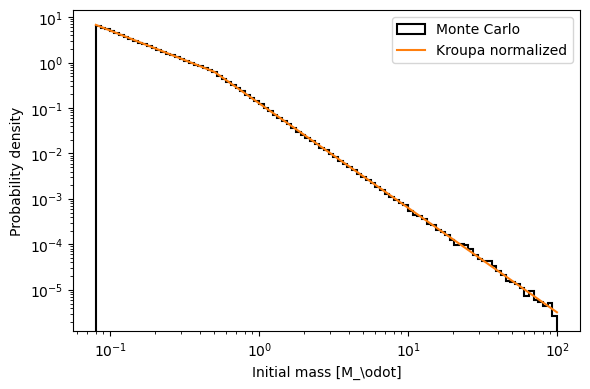

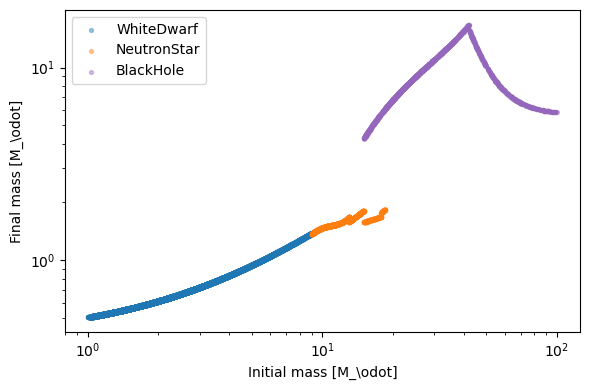

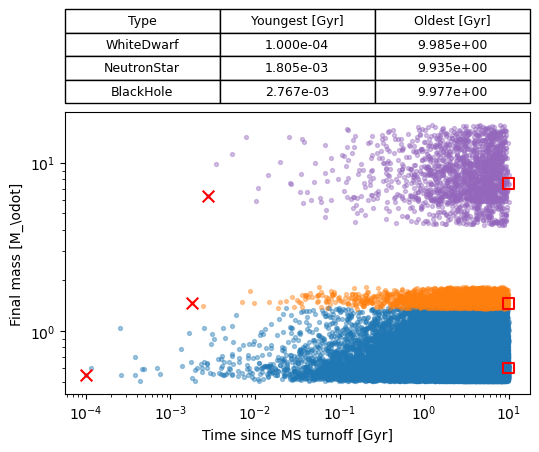

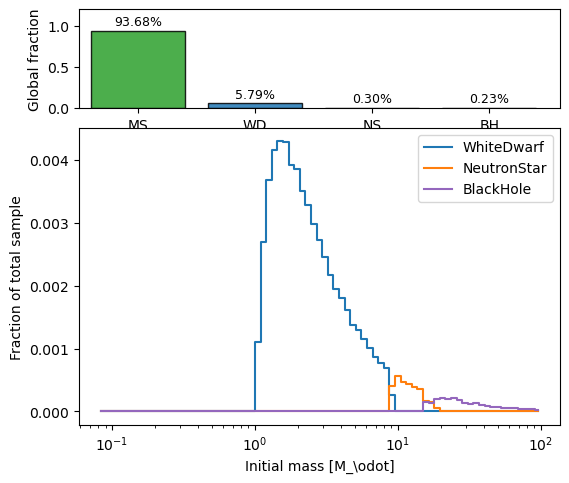

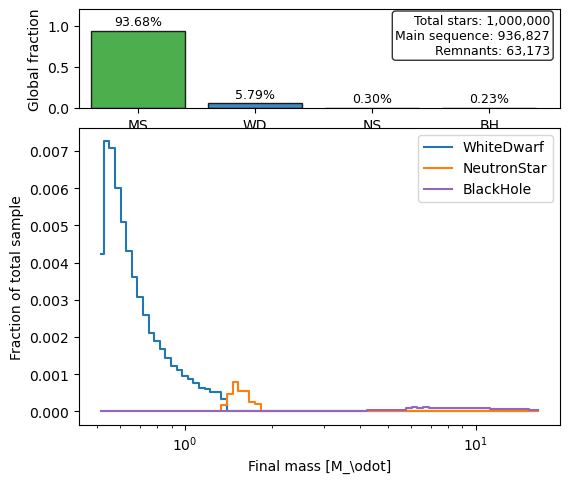

In [ ]:
# Generate all plots with a single call
generate_all_plots()
